In [3]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

A faire:
- Régler le choix de la Slice
- Faire le choix des freq en fonction de la frame systole et dystole
- uniformiser certaines histogrammes, ou qqch pour améliorer les seeds

C:\Users\maell\AppData\Local\Temp\ipykernel_39856\1468850313.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data)
C:\Users\maell\AppData\Local\Temp\ipykernel_39856\1468850313.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt = torch.tensor(patient.gt.data)


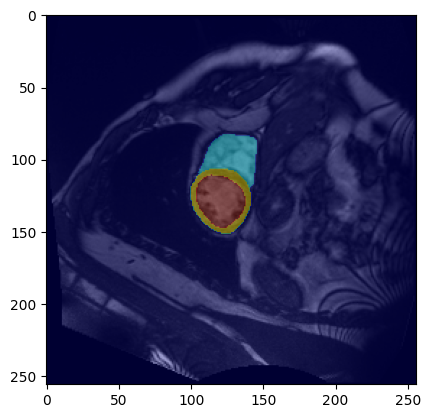

In [5]:
patient = tio.Subject(
    img=tio.ScalarImage('database/training/patient076/patient076_4d.nii.gz'),
    gt = tio.LabelMap('database/training/patient076/patient076_frame01_gt.nii.gz')
)

t_img = torch.tensor(patient.img.data)
gt = torch.tensor(patient.gt.data)
Nb_slice = t_img.shape[3]
Nb_frame = t_img.shape[0]
Tps = 0
Slice = Nb_slice//2
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')
plt.imshow(gt[0,:,:,Slice],cmap='jet', alpha=0.4)

In [3]:
def tf_mask(image4d, Tps=Tps, Slice=Slice):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    filtred[:1, :, :, :] = 0.0
    filtred[3:, :, :, :] = 0.0

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = np.ones((19, 19), np.uint8) 
    mask = cv2.dilate(mask, kernel, 1)
    mask = cv2.blur(mask,(21, 21))
    # print(np.max(mask))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m

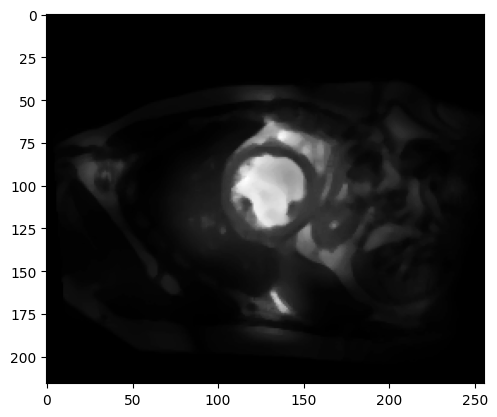

In [4]:
img_m = tf_mask(t_img)
circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0)
plt.imshow(img_m, cmap='gray')

In [5]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [6]:
def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
      cv2.circle(cimg,(i[0],i[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

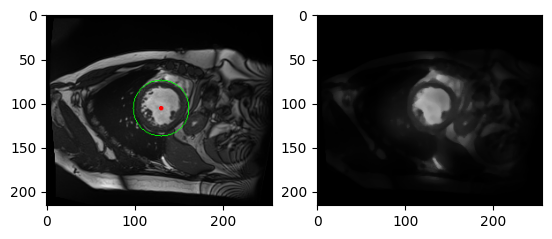

In [7]:
c_img = draw_cercles(t_img, circles)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(c_img, vmin = 0, vmax=255)
ax2.imshow(img_m, cmap="grey", vmin = 0, vmax=255)

plt.show()

In [8]:
def recherche_cercles(nb):
    reussite = 0
    for i in range (1,nb):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        t_img = torch.tensor(patient.t1.data)
        img_m = tf_mask(t_img)
        circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0)
        if circles is not None:
            reussite += 1
        c_img = draw_cercles(t_img, circles)
        cv2.imwrite(f'test_seed/cercles_{i:03d}.png', c_img)
    print(f"Reussite : {reussite}/{nb}")

In [9]:
# recherche_cercles(21)

In [10]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image, Tps=Tps, Slice=Slice):
    param2 = 40
    param1 = 2*param2
    circles = None
    stop = 0
    exec = 0 if circles is None else len(circles[0])
    while exec != 1 and stop < 100 :
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param2,minRadius=1,maxRadius=50)
        if circles is None:
            param1 -= 1
            param2 = param1/2
        elif len(circles[0]) > 1:
            param1 += 1
            param2 = param1/2
        stop += 1
        exec = 0 if circles is None else len(circles[0])
    return circles, param1, param2

In [11]:
def recherche_cercles(nb):
    reussite = 0
    for i in range (1,nb+1):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        t_img = torch.tensor(patient.t1.data)
        img_m = tf_mask(t_img)
        circles, param1, param2 = best_hough(img_m)
        if circles is None:
            print(f"Impossible de trouver un cercle pour l'image {i}")
        elif len(circles[0]) == 1:
            reussite += 1
            print(f"circles pour {i} ! param1={param1} et param2={param2}")
        c_img = draw_cercles(t_img, circles)
        cv2.imwrite(f'test_seed/cercles_{i:03d}.png', c_img)
    print(f"Reussite : {reussite}/{nb}")

In [12]:
recherche_cercles(10)

C:\Users\maell\AppData\Local\Temp\ipykernel_43024\1278626225.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


circles pour 1 ! param1=80 et param2=40
circles pour 2 ! param1=80 et param2=40
circles pour 3 ! param1=66 et param2=33.0
circles pour 4 ! param1=80 et param2=40
circles pour 5 ! param1=74 et param2=37.0
Impossible de trouver un cercle pour l'image 6
circles pour 7 ! param1=80 et param2=40
circles pour 8 ! param1=62 et param2=31.0
circles pour 9 ! param1=79 et param2=39.5
circles pour 10 ! param1=74 et param2=37.0
Reussite : 9/10


In [13]:
def seed_point(n_patient: int):
    patient = tio.Subject(
        t1=tio.ScalarImage(f'database/training/patient{n_patient:03d}/patient{n_patient:03d}_4d.nii.gz'),
    )
    t_img = torch.tensor(patient.t1.data)
    img_m = tf_mask(t_img)
    circles, param1, param2 = best_hough(img_m)
    if circles is None:
        print(f"Impossible de trouver une seed pour le patient n°{n_patient}")
        return None
    elif len(circles[0]) == 1:
        print(f"Patient {n_patient:03d} : Seed trouvée de coordonnées {circles[0][0]} pour le patient n°{n_patient}")
        c_img = draw_cercles(t_img, circles)
        return circles[0][0][:2], c_img

In [14]:
def region_growth(image,seed,error=10):
    H,L=image.shape
    left_V = np.zeros_like(image)
    visited = np.zeros_like(image, dtype=bool)

    regionplus=[seed]
    moy=image[seed[1],seed[0]]
    visited[seed[1],seed[0]]=True
    left_V[seed[1],seed[0]]=1

    while regionplus:
        new_p=[]
        for (x,y) in regionplus:
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx,ny=x+dx,y+dy
                    if 0<=nx<L and 0<=ny<H and not visited[ny,nx]:
                        if abs(image[ny,nx]-moy)<error:
                            new_p.append((nx,ny))
                            visited[ny,nx]=True
                            left_V[ny,nx]=1
        regionplus.extend(new_p)
        if new_p:
            total_intensity=sum(image[ny,nx] for (nx,ny) in regionplus)
            moy=total_intensity/len(regionplus)
        regionplus=new_p
    taille = np.sum(left_V)
    return left_V, taille

In [15]:
def leftv_seg(nb_patient, error=10, Tps=Tps, Slice=Slice):
    patient = tio.Subject(
        t1=tio.ScalarImage(f'database/training/patient{nb_patient:03d}/patient{nb_patient:03d}_4d.nii.gz'),
    )
    seed_p = seed_point(nb_patient)
    if seed_p is None:
        return None
    else :
        seed,c_img = seed_p
        seed = (int(seed[0]), int(seed[1]))
        t_img = torch.tensor(patient.t1.data)
        treshold = 15
        lv_seg, last_taille = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, treshold)
        arret = False
        while not arret:
            if treshold < 100:
                treshold+=5
                lv_seg, taille = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, treshold)
                if (taille/last_taille > 3 and last_taille > 300):
                    arret = True
                    treshold -= 5
                last_taille = taille
            else:
                treshold = 10
                arret = True
        lv_seg, taille = region_growth(np.array(t_img[Tps,:,:,Slice]),seed, treshold)
        contours = measure.find_contours(lv_seg, 0.5)
        print(f"Patient {nb_patient:03d} : Taille du ventricule gauche : {taille} pixels")
        print(f"Patient {nb_patient:03d} : Treshold : {treshold}")

        # Affichage du ventricule gauche segmenté
        plt.figure(figsize=(15,5))
        plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')
        plt.scatter(seed[0], seed[1], color='green')
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
        plt.legend(['Seed', 'Contours'])
        return lv_seg

C:\Users\maell\AppData\Local\Temp\ipykernel_43024\994854363.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


Patient 004 : Seed trouvée de coordonnées [ 89.5 131.5  28.4] pour le patient n°4
(89, 131)


C:\Users\maell\AppData\Local\Temp\ipykernel_43024\3243276944.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


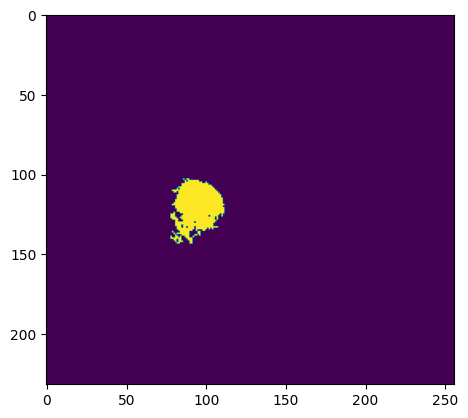

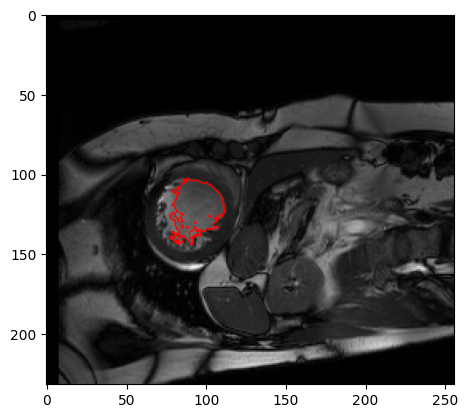

In [19]:
i = 4
patient = tio.Subject(
    t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
)
seed, c_img = seed_point(i)
seed = (int(seed[0]), int(seed[1]))
print(seed)

t_img = torch.tensor(patient.t1.data)

lv_seg, taille = region_growth(np.array(t_img[Tps,:,:,Slice]), seed, 45)
contours = measure.find_contours(lv_seg, 0.5)
plt.imshow(lv_seg)
fig, ax = plt.subplots()
ax.imshow(t_img[Tps,:,:,Slice], cmap='gray')
for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='red')
plt.show()


C:\Users\maell\AppData\Local\Temp\ipykernel_43024\994854363.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


Patient 004 : Seed trouvée de coordonnées [ 89.5 131.5  28.4] pour le patient n°4
Patient 004 : Taille du ventricule gauche : 864 pixels
Patient 004 : Treshold : 45


C:\Users\maell\AppData\Local\Temp\ipykernel_43024\4281738667.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

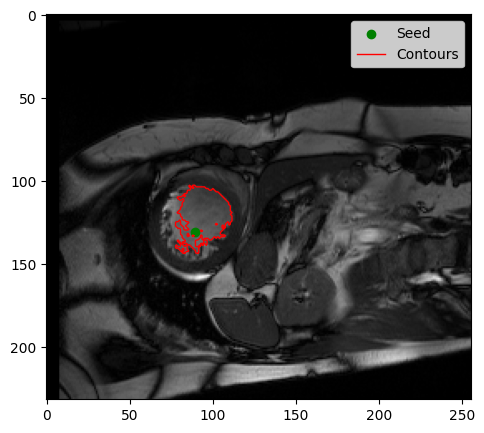

In [17]:
leftv_seg(4)

C:\Users\maell\AppData\Local\Temp\ipykernel_43024\994854363.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


Patient 001 : Seed trouvée de coordonnées [133.5 100.5  17.2] pour le patient n°1


C:\Users\maell\AppData\Local\Temp\ipykernel_43024\4281738667.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


Patient 001 : Taille du ventricule gauche : 1122 pixels
Patient 001 : Treshold : 65
Patient 002 : Seed trouvée de coordonnées [128.5 108.5  19.4] pour le patient n°2
Patient 002 : Taille du ventricule gauche : 948 pixels
Patient 002 : Treshold : 35
Patient 003 : Seed trouvée de coordonnées [140.5 104.5  28. ] pour le patient n°3
Patient 003 : Taille du ventricule gauche : 977 pixels
Patient 003 : Treshold : 50
Patient 004 : Seed trouvée de coordonnées [ 89.5 131.5  28.4] pour le patient n°4
Patient 004 : Taille du ventricule gauche : 864 pixels
Patient 004 : Treshold : 45
Patient 005 : Seed trouvée de coordonnées [114.5 126.5  20.1] pour le patient n°5
Patient 005 : Taille du ventricule gauche : 1062 pixels
Patient 005 : Treshold : 40
Impossible de trouver une seed pour le patient n°6
Patient 007 : Seed trouvée de coordonnées [120.5 113.5  20.5] pour le patient n°7
Patient 007 : Taille du ventricule gauche : 656 pixels
Patient 007 : Treshold : 35
Patient 008 : Seed trouvée de coordonné

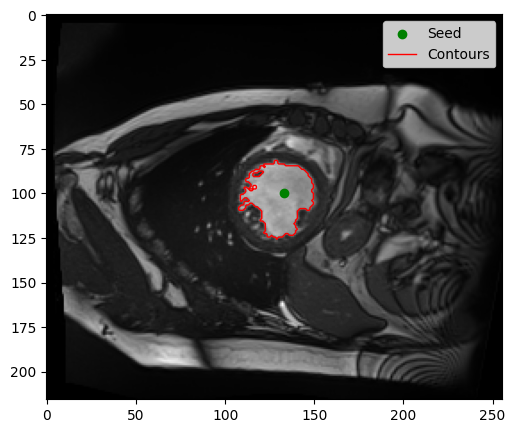

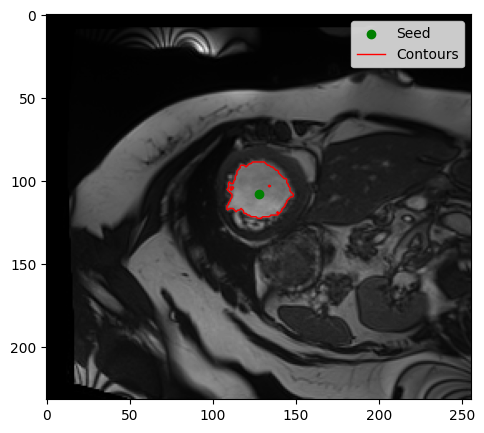

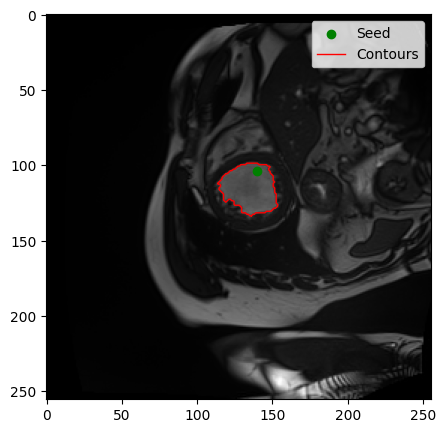

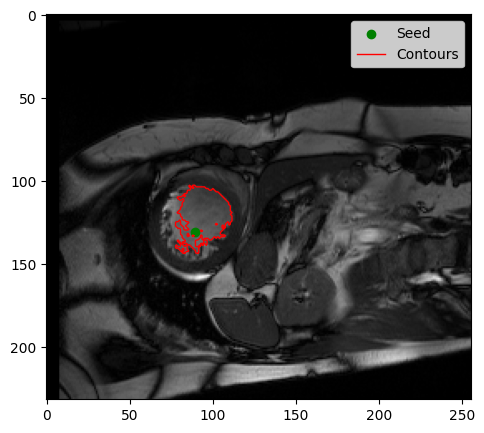

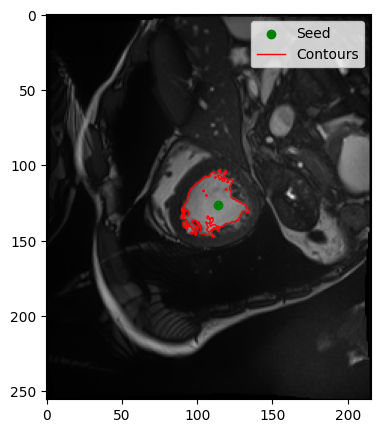

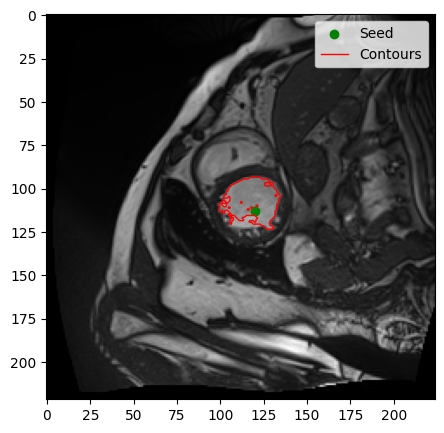

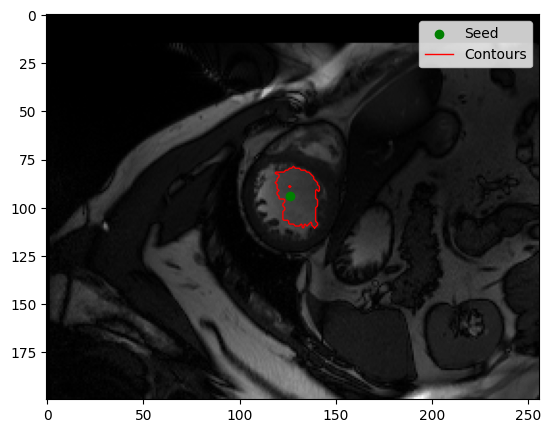

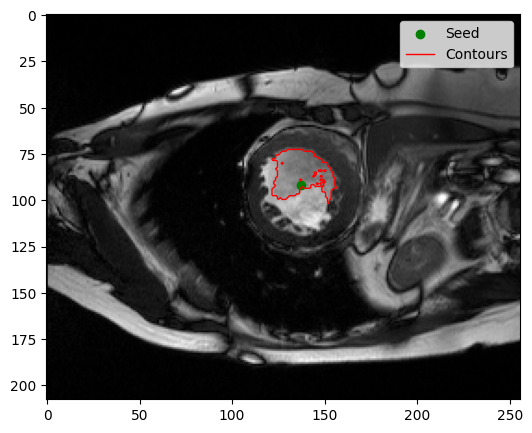

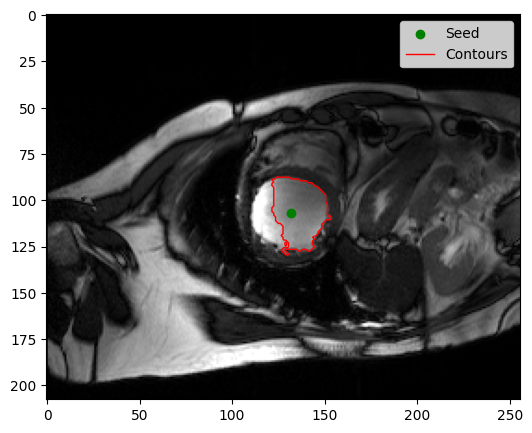

In [20]:
for i in range(1, 11):
    lv_seg = leftv_seg(int(i))
    plt.savefig(f'test_seg/lv_seg_{i:03d}.png')